# 8. Statistiques d'activation

## Reprise du code précédent

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Words

In [2]:
class Words(object):
    """Représente une liste de mots, ainsi que la liste ordonnée des caractères les composants."""

    EOS = '.'

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi[self.EOS] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [3]:
words = Words('civil_mots.txt')
print(words)

<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>


### Datasets

In [4]:
class Datasets:
    """Construits les jeu de données d'entraînement, de test et de validation.
    
    Prend en paramètres une liste de mots et la taille du contexte pour la prédiction.
    """

    def _build_dataset(self, lwords:list, context_size:int):
        X, Y = [], []
        for w in lwords:
            context = [0] * context_size
            for ch in w + self.words.EOS:
                ix = self.words.ctoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix] # crop and append
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y
    
    def __init__(self, words:Words, context_size:int, seed:int=42):
        # 80%, 10%, 10%
        self.shuffled_words = words.words.copy()
        random.shuffle(self.shuffled_words)
        self.n1 = int(0.8*len(self.shuffled_words))
        self.n2 = int(0.9*len(self.shuffled_words))
        self.words = words
        self.Xtr, self.Ytr = self._build_dataset(self.shuffled_words[:self.n1], context_size)
        self.Xdev, self.Ydev = self._build_dataset(self.shuffled_words[self.n1:self.n2], context_size)
        self.Xte, self.Yte = self._build_dataset(self.shuffled_words[self.n2:], context_size)


In [5]:
context_size = 3
datasets = Datasets(words, context_size)

### Hyperparamètres

In [6]:
vocab_size = words.nb_chars
e_dims = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the FFN
seed = 2147483647

### Réseau: classe BengioFFN

In [7]:
class BengioFFN:
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, g):
        self.g = g
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.create_network()

    def layers(self):
        self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
        fan_in = self.context_size * self.e_dims
        tanh_gain = 5/3
        self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g) * (tanh_gain / (fan_in ** 0.5))
        self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g) * 0.01  # Pour l'entropie
        self.b2 = torch.randn(self.nb_chars, generator=self.g) * 0
        self.bngain = torch.ones((1, n_hidden))
        self.bnbias = torch.zeros((1, n_hidden))

    def create_network(self):
        self.layers()
        self.loss = None
        self.steps = 0
        self.parameters = [self.C, self.W1, self.W2, self.b2, self.bngain, self.bnbias]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.bnmean_running = torch.zeros((1, n_hidden))
        self.bnstd_running = torch.zeros((1, n_hidden))

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        # Linear layer
        self.hpreact = self.embcat @ self.W1 # hidden layer pre-activation
        # BatchNorm layer
        self.bnmeani = self.hpreact.mean(0, keepdim=True)
        self.bnstdi = self.hpreact.std(0, keepdim=True)
        self.hpreact = self.bngain * (self.hpreact - self.bnmeani) / self.bnstdi + self.bnbias
        # Non linearity
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function
        # mean, std
        with torch.no_grad():
            self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
            self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * self.bnstdi

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def train(self, datasets: Datasets, max_steps, mini_batch_size):
        lossi = []
        for i in range(max_steps):
            # minibatch construct
            ix = torch.randint(0, datasets.Xtr.shape[0], (mini_batch_size,), generator=self.g)
            Xb, Yb = datasets.Xtr[ix], datasets.Ytr[ix]
            
            # forward pass
            self.forward(Xb, Yb)
        
            # backward pass
            self.backward()
        
            # update
            lr = 0.2 if i < 100000 else 0.02 # step learning rate decay
            self.update_grad(lr)
        
            # track stats
            if i % 10000 == 0:
                print(f"{i:7d}/{max_steps:7d}: {self.loss.item():.4f}")
            lossi.append(self.loss.log10().item())
        self.steps += max_steps
        return lossi

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 # hidden layer pre-activation
        hpreact = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    @torch.no_grad() # this decorator disables gradient tracking
    def training_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xtr, datasets.Ytr)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def test_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xte, datasets.Yte)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def dev_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xdev, datasets.Xdev)
        return loss.item()

    @torch.no_grad()
    def generate_word(self, itoc, g):
        out = []
        context = [0] * self.context_size
        while True:
            emb = self.C[torch.tensor([context])]
            embcat = emb.view(1, -1)
            hpreact = embcat @ self.W1
            hpreact = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias
            h = torch.tanh(hpreact)
            logits = h @ self.W2 + self.b2
            probs = F.softmax(logits, dim=1)
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Shift the context window
            context = context[1:] + [ix]
            # Store the generated character
            if ix != 0:
                out.append(ix)
            else:
                # Stop when encounting '.'
                break
        return ''.join(itoc[i] for i in out)

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  steps="{self.steps}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [8]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  loss="None"
  steps="0"
  nb_parameters="15051"/>


In [9]:
max_steps = 200000
mini_batch_size = 32
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")


      0/ 200000: 3.7006
  10000/ 200000: 2.4151
  20000/ 200000: 1.8738
  30000/ 200000: 2.2808
  40000/ 200000: 2.0681
  50000/ 200000: 1.4217
  60000/ 200000: 1.4718
  70000/ 200000: 2.2234
  80000/ 200000: 1.4571
  90000/ 200000: 1.8084
 100000/ 200000: 1.7370
 110000/ 200000: 1.5454
 120000/ 200000: 1.3682
 130000/ 200000: 1.7276
 140000/ 200000: 2.1923
 150000/ 200000: 1.3551
 160000/ 200000: 1.5709
 170000/ 200000: 1.4848
 180000/ 200000: 1.3914
 190000/ 200000: 1.6419
train_loss=1.522524118423462
val_loss=1.6819177865982056


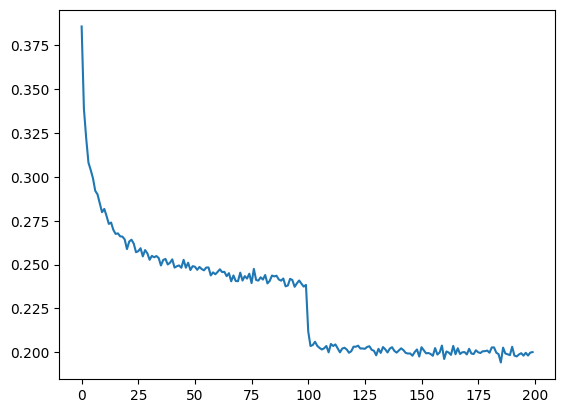

In [10]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

## "torch-ification": Linear, BatchNorm1d, vers des réseaux plus profonds

API presque identique aux classes similaires dans [torch.nn](https://pytorch.org/docs/stable/nn.html).

In [11]:
class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [12]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [13]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [ ]:
class TorchBengioFFN:
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, g):
        self.g = g
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.steps = 0
        self.create_network()

    def _create_layers(self):
        self.layers = [
            Linear(self.e_dims * self.context_size, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
            Linear(self.n_hidden, self.nb_chars), BatchNorm1d(self.nb_chars),
        ]
        with torch.no_grad():
            # last layer: make less confident
            self.layers[-1].gamma *= 0.1
            # all other layers: apply gain
            #for layer in self.layers[:-1]:
            #    if isinstance(layer, Linear):
            #        layer.weight *= 5/3

    def create_network(self):
        self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
        self._create_layers()
        self.parameters = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters:
            p.requires_grad = True
        self.nb_parameters = sum(p.nelement() for p in self.parameters)

    def forward(self, X, Y):
        emb = self.C[X] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in self.layers:
            x = layer(x)
        self.loss = F.cross_entropy(x, Y) # loss function

    def backward(self):
        for layer in self.layers:
            layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def train(self, datasets: Datasets, max_steps, mini_batch_size):
        lossi = []
        for i in range(max_steps):
            # minibatch construct
            ix = torch.randint(0, datasets.Xtr.shape[0], (mini_batch_size,), generator=self.g)
            Xb, Yb = datasets.Xtr[ix], datasets.Ytr[ix]
            
            # forward pass
            self.forward(Xb, Yb)
        
            # backward pass
            self.backward()

            # update
            lr = 0.2 if i < 100000 else 0.02 # step learning rate decay
            self.update_grad(lr)
        
            # track stats
            if i % 10000 == 0:
                print(f"{i:7d}/{max_steps:7d}: {self.loss.item():.4f}")
            lossi.append(self.loss.log10().item())
        self.steps += max_steps
        return lossi

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        x = emb.view(emb.shape[0], -1) # Concatenate the vectors
        for layer in self.layers:
            x = layer(x)
        loss = F.cross_entropy(x, Y)
        return loss

    @torch.no_grad() # this decorator disables gradient tracking
    def training_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xtr, datasets.Ytr)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def test_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xte, datasets.Yte)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def dev_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xdev, datasets.Xdev)
        return loss.item()

    @torch.no_grad()
    def generate_word(self, itoc, g):
        for layer in self.layers:
            layer.training = False
        out = []
        context = [0] * self.context_size
        while True:
            emb = self.C[torch.tensor([context])]
            x = emb.view(emb.shape[0], -1) # concatenate the vectors
            for layer in self.layers:
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=1)
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Shift the context window
            context = context[1:] + [ix]
            # Store the generated character
            if ix != 0:
                out.append(ix)
            else:
                # Stop when encounting '.'
                break
        return ''.join(itoc[i] for i in out)

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  steps="{self.steps}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [15]:
g = torch.Generator().manual_seed(seed)
nn = TorchBengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn)


<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  steps="0"
  nb_parameters="15133"/>


In [16]:
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

      0/ 200000: 3.7297
  10000/ 200000: 1.7267
  20000/ 200000: 1.8718
  30000/ 200000: 1.3533
  40000/ 200000: 1.4859
  50000/ 200000: 1.5927
  60000/ 200000: 1.8781
  70000/ 200000: 1.6199
  80000/ 200000: 1.8822
  90000/ 200000: 1.8774
 100000/ 200000: 1.8686
 110000/ 200000: 1.7877
 120000/ 200000: 1.6906
 130000/ 200000: 1.3904
 140000/ 200000: 1.7476
 150000/ 200000: 1.5275
 160000/ 200000: 1.5421
 170000/ 200000: 1.6666
 180000/ 200000: 1.3521
 190000/ 200000: 1.6354
train_loss=1.5337094068527222
val_loss=1.6885684728622437


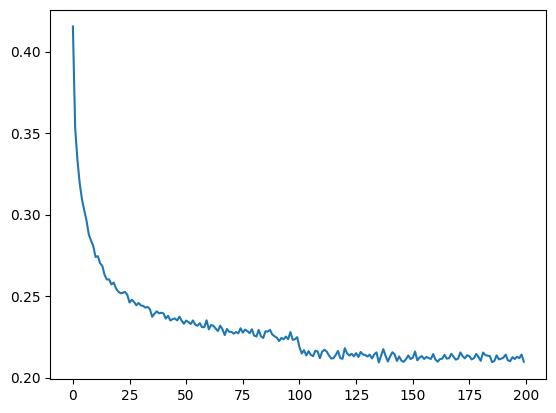

In [17]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [18]:
g = torch.Generator().manual_seed(seed + 10)
for _ in range(20):
    word = nn.generate_word(words.itoc, g)
    print(word)

aveilles
saien
impôt
répondaraîtration
compublité
expulent
posée
posée
un
condorégles
subsistement
affachés
souèvient
hes
factée
falbution
liolé
tymisespoquération
pe
nor


## Réseau plus profond


In [19]:
def _deep_create_layers(self):
    self.layers = [
        Linear(self.e_dims * self.context_size, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
    ]
    with torch.no_grad():
        # last layer: make less confident
        self.layers[-1].gamma *= 0.1
TorchBengioFFN._create_layers = _deep_create_layers

In [21]:
g = torch.Generator().manual_seed(seed)
nn = TorchBengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn)
max_steps = 200000
lossi = nn.train(datasets, max_steps, mini_batch_size)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  steps="0"
  nb_parameters="176733"/>
      0/ 200000: 3.7337
  10000/ 200000: 1.6387
  20000/ 200000: 1.5760
  30000/ 200000: 1.2514
  40000/ 200000: 1.3076
  50000/ 200000: 1.4092
  60000/ 200000: 1.6595
  70000/ 200000: 1.3982
  80000/ 200000: 1.7699
  90000/ 200000: 1.4177
 100000/ 200000: 1.7193
 110000/ 200000: 1.5801
 120000/ 200000: 1.5591
 130000/ 200000: 1.1626
 140000/ 200000: 1.4381
 150000/ 200000: 1.3407
 160000/ 200000: 1.2633
 170000/ 200000: 1.2788
 180000/ 200000: 1.1989
 190000/ 200000: 1.4888


## Fonctions utiles pour l'étude des activations: santé du réseau

### Histogramme d'activation (forward)

Visualisation par histograme de la distribution des **activations** lors de la **passe avant**, pour les couches `Tanh`.
On calcule la moyenne, l'écart-type et la saturation (`t.abs() > 0.97`) des valeurs.

- Visualiser la sortie des `tanh`.
- **Objectif :** une distribution étalée. Éviter les pics exclusifs à -1 et +1 (saturation).
- **Alerte :** comme vu précédemment, si une colonne est 100% blanche (toujours saturée), le neurone est mort.


In [22]:
def plot_forward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 0.75, saturated: 24.47%
layer 5 (      Tanh): mean -0.00, std 0.80, saturated: 28.20%
layer 8 (      Tanh): mean +0.01, std 0.81, saturated: 29.75%
layer 11 (      Tanh): mean +0.01, std 0.81, saturated: 29.84%
layer 14 (      Tanh): mean -0.00, std 0.82, saturated: 29.47%


/var/folders/f3/nrzvpdb51b7f_cd_50qlhsvr0000gn/T/ipykernel_82618/2139251471.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


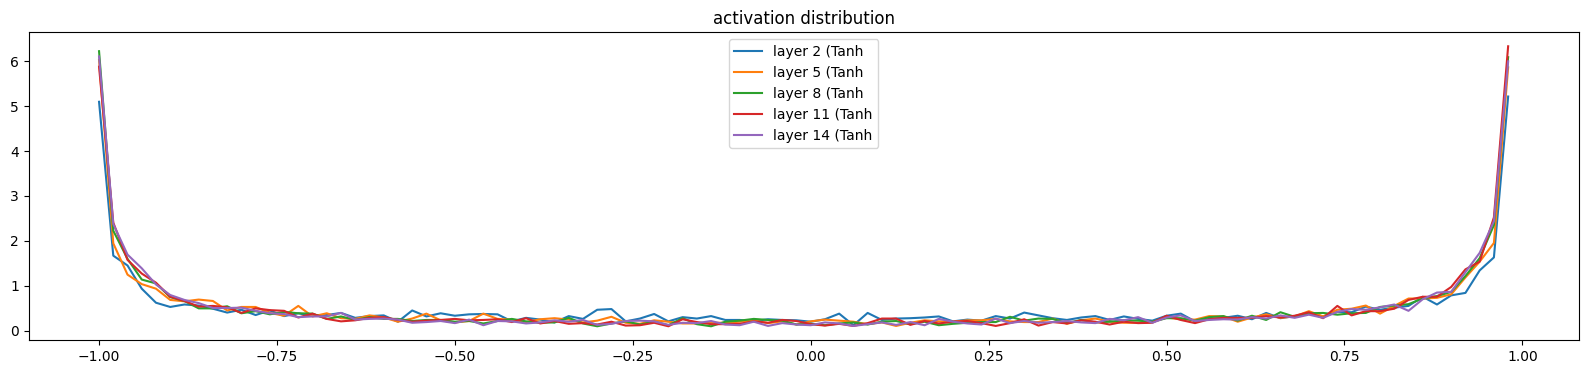

In [23]:
plot_forward_tanh(nn.layers)

### Histogrammes des gradients (backward)

* Visualiser les gradients des poids à chaque couche.
* **Objectif :** Les gradients doivent avoir la même échelle (même écart-type) dans toutes les couches. Sinon, on a un problème de *vanishing* ou *exploding gradient*.


In [24]:
def plot_backward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
      if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')

layer 2 (      Tanh): mean -0.000000, std 2.198041e-03
layer 5 (      Tanh): mean -0.000000, std 2.340218e-03
layer 8 (      Tanh): mean -0.000000, std 2.221729e-03
layer 11 (      Tanh): mean -0.000000, std 1.866999e-03
layer 14 (      Tanh): mean -0.000000, std 2.408152e-03


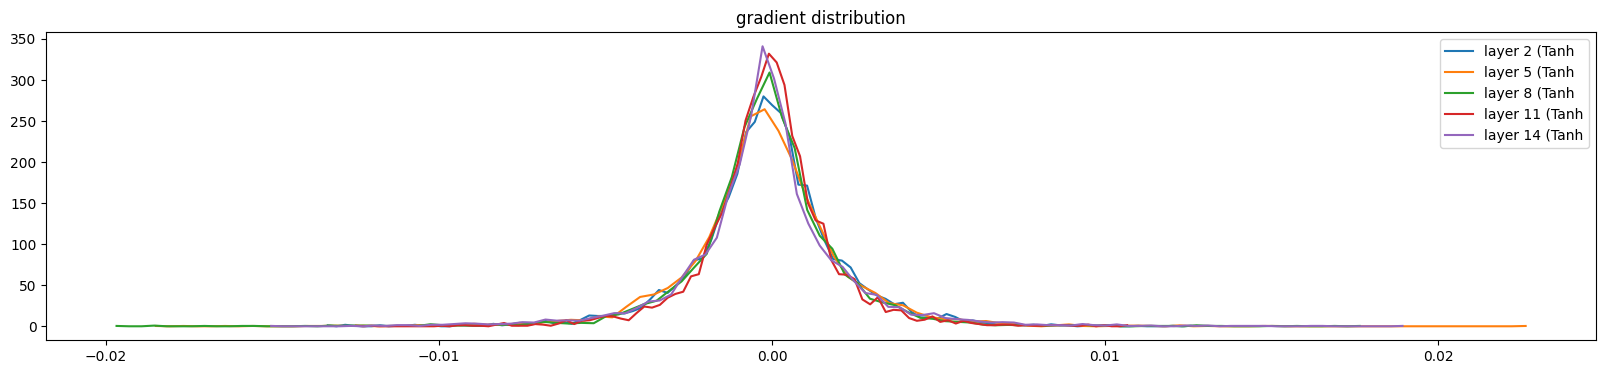

In [25]:
plot_backward_tanh(nn.layers)

## Exemples

### Test sans l'utilisation de 5/3

In [75]:
def _deep_create_layers(self):
    self.layers = [
        Linear(self.e_dims * self.context_size, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ]
    with torch.no_grad():
      # last layer: make less confident
      self.layers[-1].weight *= 0.1
      #for layer in self.layers[:-1]:
      #  if isinstance(layer, Linear):
      #    layer.weight *= 0. #5/3
TorchBengioFFN._create_layers = _deep_create_layers

In [76]:
g = torch.Generator().manual_seed(seed)
nn_no_kaiming = TorchBengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn_no_kaiming)
max_steps = 10000
lossi = nn_no_kaiming.train(datasets, max_steps, mini_batch_size)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  steps="0"
  nb_parameters="175651"/>
      0/  10000: 3.7123


layer 1 (      Tanh): mean +0.00, std 0.77, saturated: 21.77%
layer 3 (      Tanh): mean -0.01, std 0.83, saturated: 35.48%
layer 5 (      Tanh): mean -0.01, std 0.85, saturated: 39.14%
layer 7 (      Tanh): mean -0.03, std 0.84, saturated: 37.41%
layer 9 (      Tanh): mean -0.00, std 0.62, saturated: 18.83%


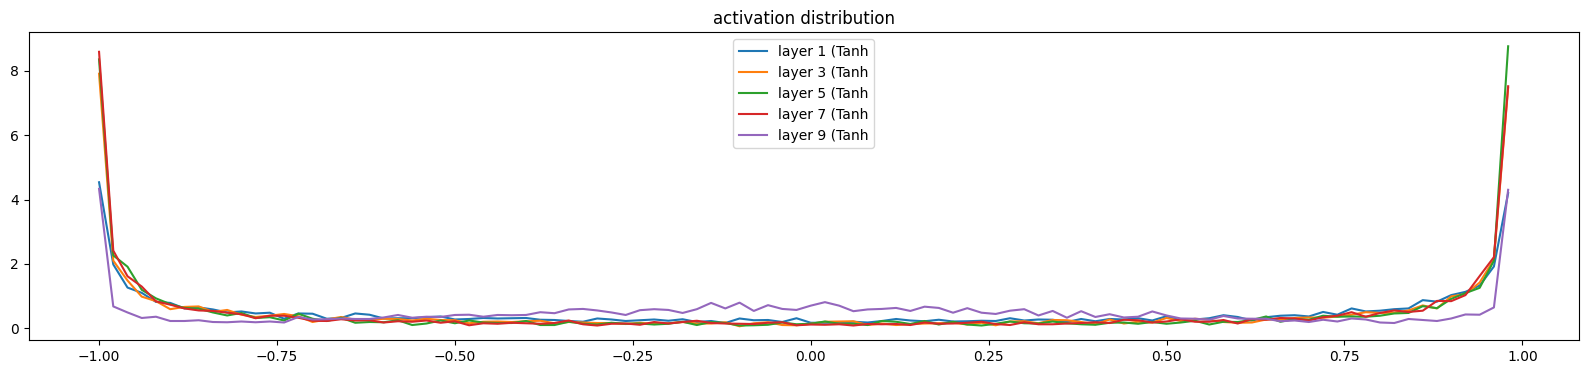

In [77]:
plot_forward_tanh(nn_no_kaiming.layers)

### Initialisation avec un facteur trop grand

In [72]:
def _deep_create_layers(self):
    self.layers = [
        Linear(self.e_dims * self.context_size, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(                  self.n_hidden, self.n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ]
    with torch.no_grad():
      # last layer: make less confident
      self.layers[-1].weight *= 0.1
      for layer in self.layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 3
TorchBengioFFN._create_layers = _deep_create_layers

In [73]:
g = torch.Generator().manual_seed(seed)
nn_no_kaiming = TorchBengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn_no_kaiming)
max_steps = 1000
lossi = nn_no_kaiming.train(datasets, max_steps, mini_batch_size)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  steps="0"
  nb_parameters="175651"/>
      0/   1000: 3.7604


layer 1 (      Tanh): mean -0.02, std 0.87, saturated: 49.48%
layer 3 (      Tanh): mean -0.01, std 0.88, saturated: 53.16%
layer 5 (      Tanh): mean -0.01, std 0.90, saturated: 56.61%
layer 7 (      Tanh): mean -0.01, std 0.89, saturated: 54.00%
layer 9 (      Tanh): mean +0.01, std 0.86, saturated: 47.20%


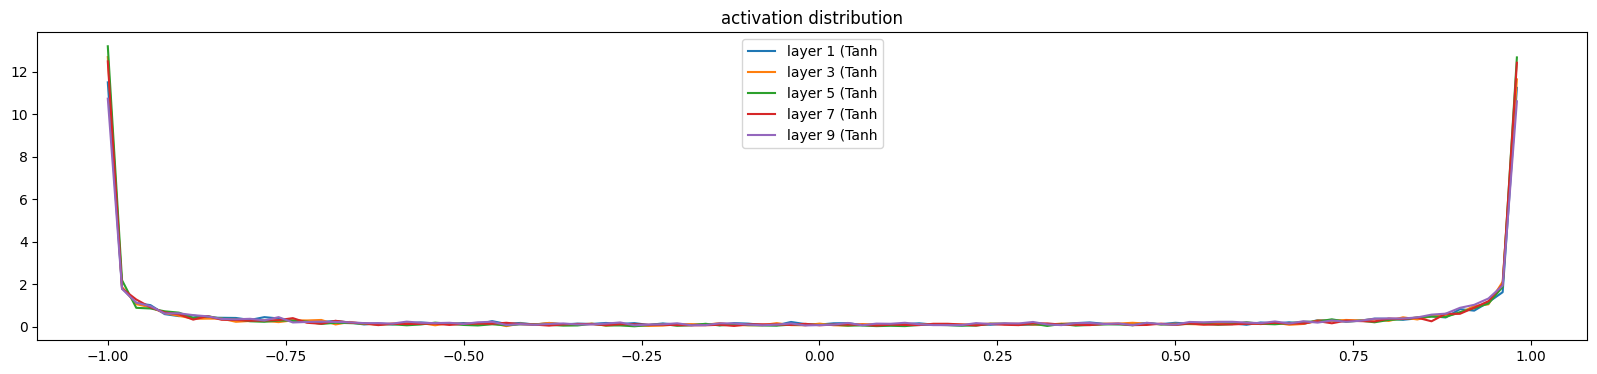

In [74]:
plot_forward_tanh(nn_no_kaiming.layers)